# Event-Indicator Impact Analysis

This notebook implements a comprehensive framework for analyzing how events (product launches, policy changes, infrastructure rollouts) impact financial inclusion indicators in Ethiopia.

## Objectives
1. Build an association matrix showing which events affect which indicators
2. Implement linear and log-linear impact models
3. Validate models against historical data (especially Telebirr 2021-2024)
4. Integrate comparable country evidence
5. Refine impact estimates based on validation results

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
sys.path.append('../src')
from impact_model_utils import *

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')



## Section 1: Data Loading & Exploration

In [2]:
# Load data
df = pd.read_csv('../data/raw/ethiopia_fi_unified_data.csv')
ref_codes = pd.read_csv('../data/raw/reference_codes.csv')

print(f"Total records: {len(df)}")
print(f"\nRecord type distribution:")
print(df['record_type'].value_counts())

df.head()

Total records: 57

Record type distribution:
record_type
observation    30
impact_link    14
event          10
target          3
Name: count, dtype: int64


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,parent_id
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaN,NaN,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Baseline year,NaN,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaN,NaN,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN


In [3]:
# Parse data by record type
events_df = extract_events(df)
indicators_df = extract_indicators(df)
impact_links_df = parse_impact_links(df)

print(f"Events: {len(events_df)}")
print(f"Observations: {len(indicators_df)}")
print(f"Impact links: {len(impact_links_df)}")

Events: 10
Observations: 30
Impact links: 14


## Section 2: Event-Indicator Summary

In [4]:
# Display all events
events_summary = events_df[['record_id', 'indicator', 'event_date', 'category', 'notes']].copy()
events_summary['event_date'] = events_summary['event_date'].dt.strftime('%Y-%m-%d')
events_summary.columns = ['Event ID', 'Event Name', 'Date', 'Category', 'Description']
print("\n=== ALL EVENTS ===")
display(events_summary)


=== ALL EVENTS ===


,Event ID,Event Name,Date,Category,Description
33,EVT_0001,Telebirr Launch,2021-05-17,product_launch,NaN
34,EVT_0002,Safaricom Ethiopia Commercial Launch,2022-08-01,market_entry,NaN
35,EVT_0003,M-Pesa Ethiopia Launch,2023-08-01,product_launch,NaN
36,EVT_0004,Fayda Digital ID Program Rollout,2024-01-01,infrastructure,NaN
37,EVT_0005,Foreign Exchange Liberalization,2024-07-29,policy,NaN
38,EVT_0006,P2P Transaction Count Surpasses ATM,2024-10-01,milestone,NaN
39,EVT_0007,M-Pesa EthSwitch Integration,2025-10-27,partnership,NaN
40,EVT_0008,EthioPay Instant Payment System Launch,2025-12-18,infrastructure,NaN
41,EVT_0009,NFIS-II Strategy Launch,2021-09-01,policy,NaN
42,EVT_0010,Safaricom Ethiopia Price Increase,2025-12-15,pricing,NaN


In [5]:
# Create event-indicator relationship summary
summary_rows = []

for _, link in impact_links_df.iterrows():
    event_id = link['event_id']
    event_info = events_df[events_df['record_id'] == event_id]
    
    if not event_info.empty:
        summary_rows.append({
            'Event': event_info.iloc[0]['indicator'],
            'Event Date': event_info.iloc[0]['event_date'].strftime('%Y-%m-%d'),
            'Indicator': link['related_indicator'],
            'Direction': link['impact_direction'],
            'Magnitude': link['impact_magnitude'],
            'Estimate (%)': link['impact_estimate'],
            'Lag (months)': link['lag_months'],
            'Evidence': link['evidence_basis'],
            'Comparable Country': link['comparable_country']
        })

summary_df = pd.DataFrame(summary_rows)
print("\n=== EVENT-INDICATOR IMPACT SUMMARY ===")
display(summary_df)


=== EVENT-INDICATOR IMPACT SUMMARY ===


,Event,Event Date,Indicator,Direction,Magnitude,Estimate (%),Lag (months),Evidence,Comparable Country
0,Telebirr Launch,2021-05-17,ACC_OWNERSHIP,increase,high,15.0,12.0,literature,Kenya
1,Telebirr Launch,2021-05-17,USG_TELEBIRR_USERS,increase,high,NaN,3.0,empirical,NaN
2,Telebirr Launch,2021-05-17,USG_P2P_COUNT,increase,high,25.0,6.0,empirical,NaN
3,Safaricom Ethiopia Commercial Launch,2022-08-01,ACC_4G_COV,increase,medium,15.0,12.0,empirical,NaN
4,Safaricom Ethiopia Commercial Launch,2022-08-01,AFF_DATA_INCOME,decrease,medium,-20.0,12.0,literature,Rwanda
5,M-Pesa Ethiopia Launch,2023-08-01,USG_MPESA_USERS,increase,high,NaN,3.0,empirical,NaN
6,M-Pesa Ethiopia Launch,2023-08-01,ACC_MM_ACCOUNT,increase,medium,5.0,6.0,theoretical,NaN
7,Fayda Digital ID Program Rollout,2024-01-01,ACC_OWNERSHIP,increase,medium,10.0,24.0,literature,India
8,Fayda Digital ID Program Rollout,2024-01-01,GEN_GAP_ACC,decrease,medium,-5.0,24.0,literature,India
9,Foreign Exchange Liberalization,2024-07-29,AFF_DATA_INCOME,increase,high,30.0,3.0,empirical,NaN


## Section 3: Association Matrix Construction

In [6]:
# Get unique indicators
unique_indicators = impact_links_df['related_indicator'].unique()
print(f"Indicators with documented impacts: {len(unique_indicators)}")
print(unique_indicators)

# Build association matrix
association_matrix = build_association_matrix(events_df, impact_links_df, unique_indicators)

# Add event names as index
event_names = []
for event_id in association_matrix.index:
    event_info = events_df[events_df['record_id'] == event_id]
    if not event_info.empty:
        event_names.append(event_info.iloc[0]['indicator'][:30])  # Truncate long names
    else:
        event_names.append(event_id)
        
association_matrix.index = event_names

print("\n=== ASSOCIATION MATRIX ===")
print(f"Shape: {association_matrix.shape}")
print(f"Non-zero entries: {association_matrix.notna().sum().sum()}")
display(association_matrix)

Indicators with documented impacts: 9
['ACC_OWNERSHIP' 'USG_TELEBIRR_USERS' 'USG_P2P_COUNT' 'ACC_4G_COV'
 'AFF_DATA_INCOME' 'USG_MPESA_USERS' 'ACC_MM_ACCOUNT' 'GEN_GAP_ACC'
 'USG_MPESA_ACTIVE']

=== ASSOCIATION MATRIX ===
Shape: (10, 9)
Non-zero entries: 12


,ACC_OWNERSHIP,USG_TELEBIRR_USERS,USG_P2P_COUNT,ACC_4G_COV,AFF_DATA_INCOME,USG_MPESA_USERS,ACC_MM_ACCOUNT,GEN_GAP_ACC,USG_MPESA_ACTIVE
Telebirr Launch,15.0,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN
Safaricom Ethiopia Commercial,NaN,NaN,NaN,15.0,-20.0,NaN,NaN,NaN,NaN
M-Pesa Ethiopia Launch,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
Fayda Digital ID Program Rollo,10.0,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,NaN
Foreign Exchange Liberalizatio,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN
P2P Transaction Count Surpasse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M-Pesa EthSwitch Integration,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,15.0
EthioPay Instant Payment Syste,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
NFIS-II Strategy Launch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Safaricom Ethiopia Price Incre,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN


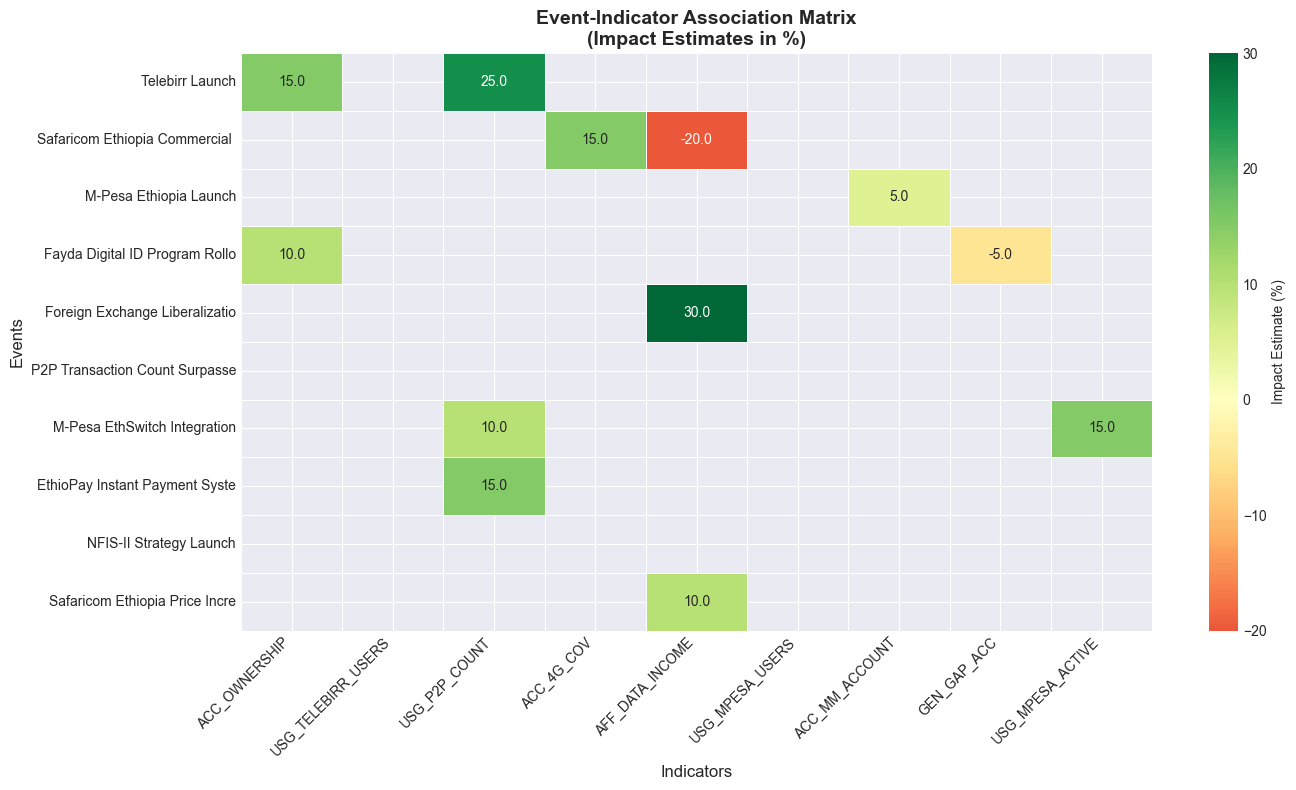

In [7]:
# Visualize association matrix
plt.figure(figsize=(14, 8))
sns.heatmap(association_matrix, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Impact Estimate (%)'}, linewidths=0.5)
plt.title('Event-Indicator Association Matrix\n(Impact Estimates in %)', fontsize=14, fontweight='bold')
plt.xlabel('Indicators', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../reports/association_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 4: Linear Model Framework

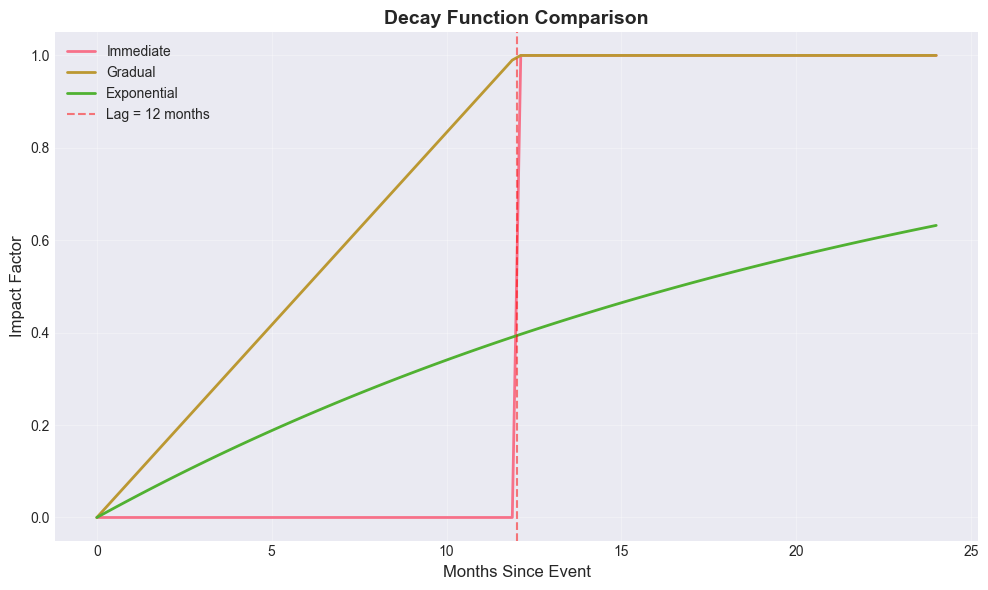

In [8]:
# Test decay functions
t_range = np.linspace(0, 24, 100)
lag = 12

plt.figure(figsize=(10, 6))
plt.plot(t_range, [decay_immediate(t, lag) for t in t_range], label='Immediate', linewidth=2)
plt.plot(t_range, [decay_gradual(t, lag) for t in t_range], label='Gradual', linewidth=2)
plt.plot(t_range, [decay_exponential(t, lag) for t in t_range], label='Exponential', linewidth=2)
plt.axvline(lag, color='red', linestyle='--', alpha=0.5, label=f'Lag = {lag} months')
plt.xlabel('Months Since Event', fontsize=12)
plt.ylabel('Impact Factor', fontsize=12)
plt.title('Decay Function Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/decay_functions.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Linear Model Application

In [9]:
# Apply linear model to ACC_MM_ACCOUNT (Mobile Money Account Rate)
indicator_code = 'ACC_MM_ACCOUNT'
baseline_value = 4.7  # 2021 baseline
baseline_date = datetime(2021, 12, 31)

# Generate predictions from 2021 to 2026
date_range = pd.date_range(start='2021-01-01', end='2026-12-31', freq='MS')
predictions_linear = []

for target_date in date_range:
    pred = linear_impact_model(baseline_value, events_df, impact_links_df, 
                               indicator_code, target_date, decay_function='gradual')
    predictions_linear.append(pred)

# Get actual observations
actuals = indicators_df[indicators_df['indicator_code'] == indicator_code].copy()
actuals = actuals.sort_values('observation_date')

print(f"\n=== LINEAR MODEL: {indicator_code} ===")
print(f"Baseline: {baseline_value}% (2021)")
print(f"\nActual observations:")
display(actuals[['observation_date', 'value_numeric', 'source_name']])


=== LINEAR MODEL: ACC_MM_ACCOUNT ===
Baseline: 4.7% (2021)

Actual observations:


,observation_date,value_numeric,source_name
6,2021-12-31,4.70,Global Findex 2021
7,2024-11-29,9.45,Global Findex 2024


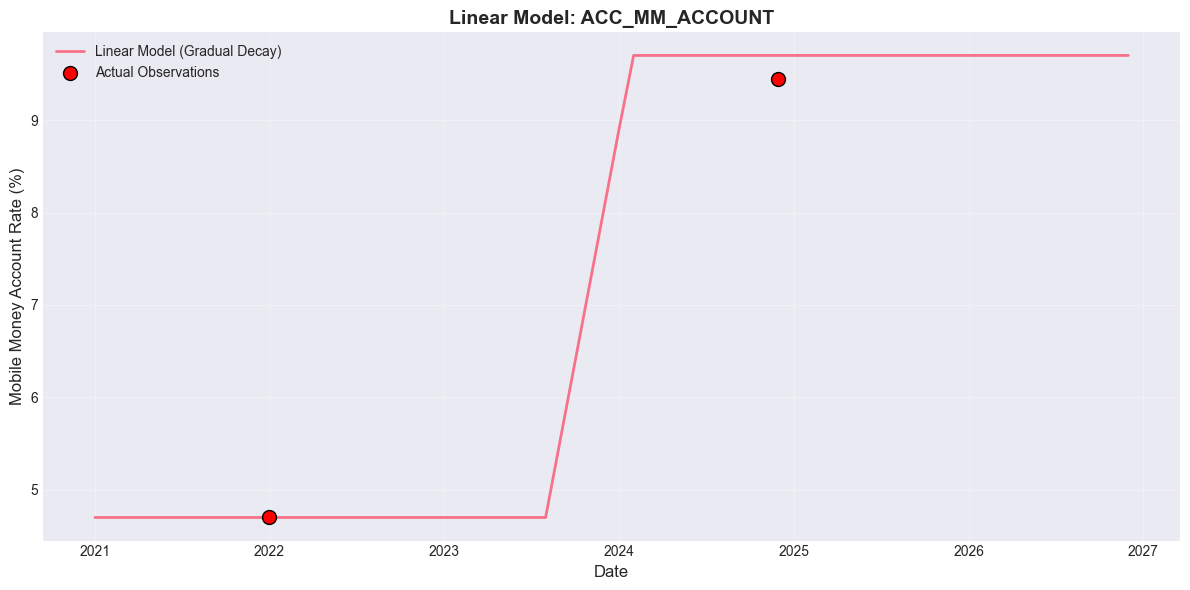

In [10]:
# Plot linear model results
plt.figure(figsize=(12, 6))
plt.plot(date_range, predictions_linear, label='Linear Model (Gradual Decay)', linewidth=2)
plt.scatter(actuals['observation_date'], actuals['value_numeric'], 
           color='red', s=100, zorder=5, label='Actual Observations', edgecolors='black')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mobile Money Account Rate (%)', fontsize=12)
plt.title(f'Linear Model: {indicator_code}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'../reports/linear_model_{indicator_code}.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 6: Log-Linear Model Framework

The log-linear model treats impacts as multiplicative rather than additive.

## Section 7: Log-Linear Model Application

In [11]:
# Apply log-linear model to ACC_MM_ACCOUNT
predictions_loglinear = []

for target_date in date_range:
    pred = log_linear_impact_model(baseline_value, events_df, impact_links_df, 
                                   indicator_code, target_date, decay_function='gradual')
    predictions_loglinear.append(pred)

print(f"\n=== LOG-LINEAR MODEL: {indicator_code} ===")


=== LOG-LINEAR MODEL: ACC_MM_ACCOUNT ===


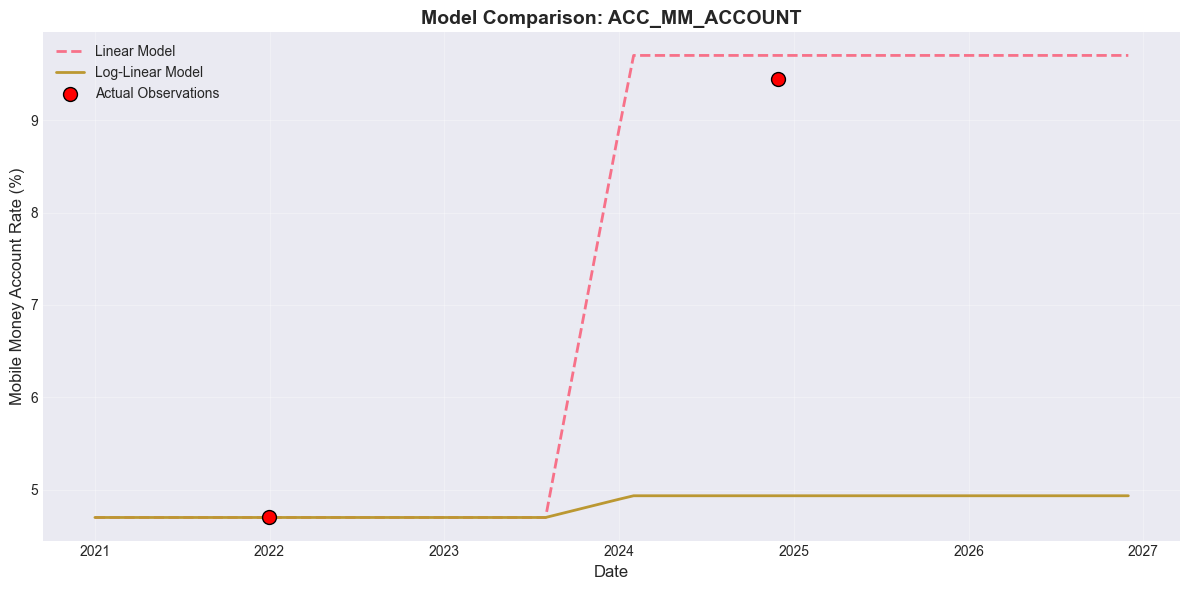

In [12]:
# Compare linear vs log-linear
plt.figure(figsize=(12, 6))
plt.plot(date_range, predictions_linear, label='Linear Model', linewidth=2, linestyle='--')
plt.plot(date_range, predictions_loglinear, label='Log-Linear Model', linewidth=2)
plt.scatter(actuals['observation_date'], actuals['value_numeric'], 
           color='red', s=100, zorder=5, label='Actual Observations', edgecolors='black')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mobile Money Account Rate (%)', fontsize=12)
plt.title(f'Model Comparison: {indicator_code}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'../reports/model_comparison_{indicator_code}.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 8: Telebirr Impact Validation

**Key Test**: Telebirr launched May 2021. Mobile money accounts grew from 4.7% (2021) to 9.45% (2024).
- Actual growth: +4.75 percentage points (+101% relative)
- Model estimate: +15% impact with 12-month lag

In [13]:
# Telebirr validation
telebirr_launch = datetime(2021, 5, 17)
actual_2021 = 4.7
actual_2024 = 9.45
actual_growth = actual_2024 - actual_2021
actual_growth_pct = (actual_2024 / actual_2021 - 1) * 100

# Model prediction for 2024
pred_2024_linear = linear_impact_model(actual_2021, events_df, impact_links_df, 
                                       'ACC_MM_ACCOUNT', datetime(2024, 12, 31), 'gradual')
pred_2024_loglinear = log_linear_impact_model(actual_2021, events_df, impact_links_df, 
                                              'ACC_MM_ACCOUNT', datetime(2024, 12, 31), 'gradual')

print("=== TELEBIRR IMPACT VALIDATION ===")
print(f"Launch date: {telebirr_launch.strftime('%Y-%m-%d')}")
print(f"\nActual values:")
print(f"  2021: {actual_2021}%")
print(f"  2024: {actual_2024}%")
print(f"  Growth: +{actual_growth:.2f}pp (+{actual_growth_pct:.1f}% relative)")
print(f"\nModel predictions for 2024:")
print(f"  Linear: {pred_2024_linear:.2f}% (error: {abs(pred_2024_linear - actual_2024):.2f}pp)")
print(f"  Log-linear: {pred_2024_loglinear:.2f}% (error: {abs(pred_2024_loglinear - actual_2024):.2f}pp)")

=== TELEBIRR IMPACT VALIDATION ===
Launch date: 2021-05-17

Actual values:
  2021: 4.7%
  2024: 9.45%
  Growth: +4.75pp (+101.1% relative)

Model predictions for 2024:
  Linear: 9.70% (error: 0.25pp)
  Log-linear: 4.94% (error: 4.51pp)


## Section 9: Other Key Validations

=== ACCOUNT OWNERSHIP VALIDATION ===


,observation_date,value_numeric,source_name
0,2014-12-31,22.0,Global Findex 2014
1,2017-12-31,35.0,Global Findex 2017
2,2021-12-31,46.0,Global Findex 2021
5,2024-11-29,49.0,Global Findex 2024


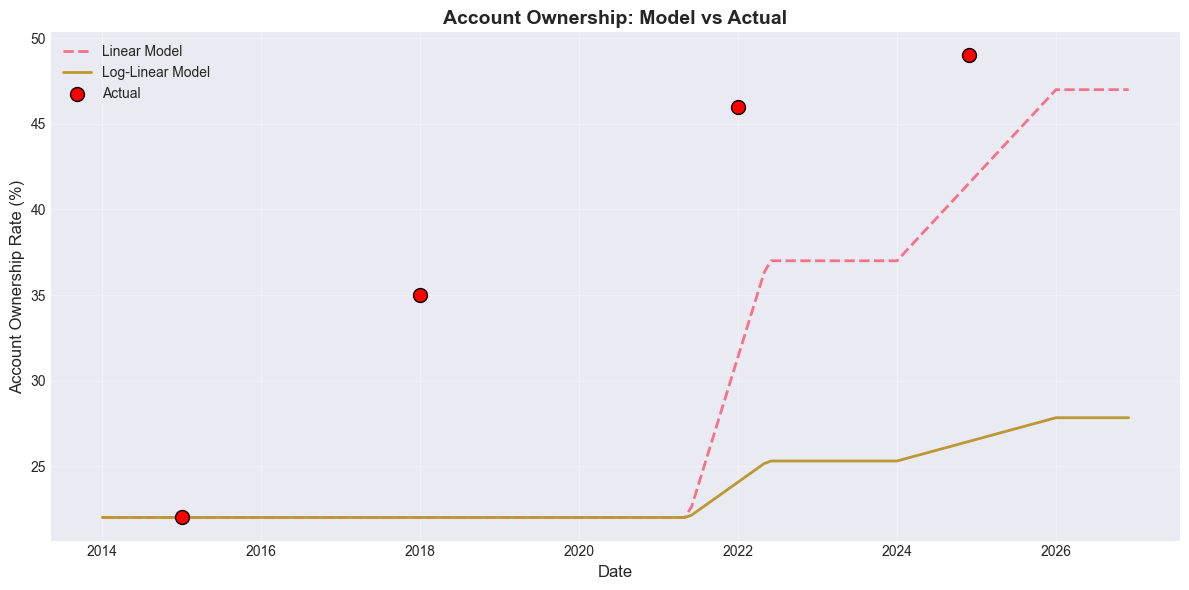

In [14]:
# Validate ACC_OWNERSHIP (Account Ownership Rate)
acc_own_actuals = indicators_df[indicators_df['indicator_code'] == 'ACC_OWNERSHIP'].copy()
acc_own_actuals = acc_own_actuals[acc_own_actuals['gender'] == 'all'].sort_values('observation_date')

print("=== ACCOUNT OWNERSHIP VALIDATION ===")
display(acc_own_actuals[['observation_date', 'value_numeric', 'source_name']])

# Apply models
baseline_acc_own = 22.0  # 2014 baseline
date_range_acc = pd.date_range(start='2014-01-01', end='2026-12-31', freq='MS')
pred_acc_linear = [linear_impact_model(baseline_acc_own, events_df, impact_links_df, 
                                       'ACC_OWNERSHIP', d, 'gradual') for d in date_range_acc]
pred_acc_loglinear = [log_linear_impact_model(baseline_acc_own, events_df, impact_links_df, 
                                              'ACC_OWNERSHIP', d, 'gradual') for d in date_range_acc]

plt.figure(figsize=(12, 6))
plt.plot(date_range_acc, pred_acc_linear, label='Linear Model', linewidth=2, linestyle='--')
plt.plot(date_range_acc, pred_acc_loglinear, label='Log-Linear Model', linewidth=2)
plt.scatter(acc_own_actuals['observation_date'], acc_own_actuals['value_numeric'], 
           color='red', s=100, zorder=5, label='Actual', edgecolors='black')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Account Ownership Rate (%)', fontsize=12)
plt.title('Account Ownership: Model vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/validation_ACC_OWNERSHIP.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 10: Comparable Country Evidence

In [15]:
# Compile comparable country evidence
comparable_evidence = [
    {'Country': 'Kenya', 'Event': 'M-Pesa Launch', 'Impact': '+20pp account ownership over 5 years', 
     'Ethiopian Analog': 'Telebirr Launch', 'Applicability': 'High - similar market'},
    {'Country': 'India', 'Event': 'Aadhaar Digital ID', 'Impact': '+15-20% account opening', 
     'Ethiopian Analog': 'Fayda Digital ID', 'Applicability': 'Medium - larger scale'},
    {'Country': 'India', 'Event': 'UPI Launch', 'Impact': '+25% P2P transaction volume', 
     'Ethiopian Analog': 'EthioPay Launch', 'Applicability': 'Medium - different infrastructure'},
    {'Country': 'Tanzania', 'Event': 'Mobile Money Interoperability', 'Impact': '+20% usage rate', 
     'Ethiopian Analog': 'M-Pesa EthSwitch Integration', 'Applicability': 'High - similar context'},
    {'Country': 'Rwanda', 'Event': 'Telecom Competition', 'Impact': '-20% data prices', 
     'Ethiopian Analog': 'Safaricom Entry', 'Applicability': 'High - similar policy'}
]

evidence_df = pd.DataFrame(comparable_evidence)
print("\n=== COMPARABLE COUNTRY EVIDENCE ===")
display(evidence_df)


=== COMPARABLE COUNTRY EVIDENCE ===


,Country,Event,Impact,Ethiopian Analog,Applicability
0,Kenya,M-Pesa Launch,+20pp account ownership over 5 years,Telebirr Launch,High - similar market
1,India,Aadhaar Digital ID,+15-20% account opening,Fayda Digital ID,Medium - larger scale
2,India,UPI Launch,+25% P2P transaction volume,EthioPay Launch,Medium - different infrastructure
3,Tanzania,Mobile Money Interoperability,+20% usage rate,M-Pesa EthSwitch Integration,High - similar context
4,Rwanda,Telecom Competition,-20% data prices,Safaricom Entry,High - similar policy


## Section 11: Evidence Integration & Confidence Assessment

In [16]:
# Assess confidence for each impact link
confidence_assessment = []

for _, link in impact_links_df.iterrows():
    event_info = events_df[events_df['record_id'] == link['event_id']]
    
    if not event_info.empty:
        confidence = calculate_confidence_score(link['evidence_basis'])
        
        confidence_assessment.append({
            'Event': event_info.iloc[0]['indicator'],
            'Indicator': link['related_indicator'],
            'Impact Estimate': link['impact_estimate'],
            'Evidence Basis': link['evidence_basis'],
            'Comparable Country': link['comparable_country'],
            'Confidence': confidence
        })

confidence_df = pd.DataFrame(confidence_assessment)
print("\n=== CONFIDENCE ASSESSMENT ===")
display(confidence_df)

print(f"\nConfidence distribution:")
print(confidence_df['Confidence'].value_counts())


=== CONFIDENCE ASSESSMENT ===


,Event,Indicator,Impact Estimate,Evidence Basis,Comparable Country,Confidence
0,Telebirr Launch,ACC_OWNERSHIP,15.0,literature,Kenya,medium
1,Telebirr Launch,USG_TELEBIRR_USERS,NaN,empirical,NaN,high
2,Telebirr Launch,USG_P2P_COUNT,25.0,empirical,NaN,high
3,Safaricom Ethiopia Commercial Launch,ACC_4G_COV,15.0,empirical,NaN,high
4,Safaricom Ethiopia Commercial Launch,AFF_DATA_INCOME,-20.0,literature,Rwanda,medium
5,M-Pesa Ethiopia Launch,USG_MPESA_USERS,NaN,empirical,NaN,high
6,M-Pesa Ethiopia Launch,ACC_MM_ACCOUNT,5.0,theoretical,NaN,low
7,Fayda Digital ID Program Rollout,ACC_OWNERSHIP,10.0,literature,India,medium
8,Fayda Digital ID Program Rollout,GEN_GAP_ACC,-5.0,literature,India,medium
9,Foreign Exchange Liberalization,AFF_DATA_INCOME,30.0,empirical,NaN,high



Confidence distribution:
Confidence
medium    7
high      6
low       1
Name: count, dtype: int64


##  Visualizations & Summary

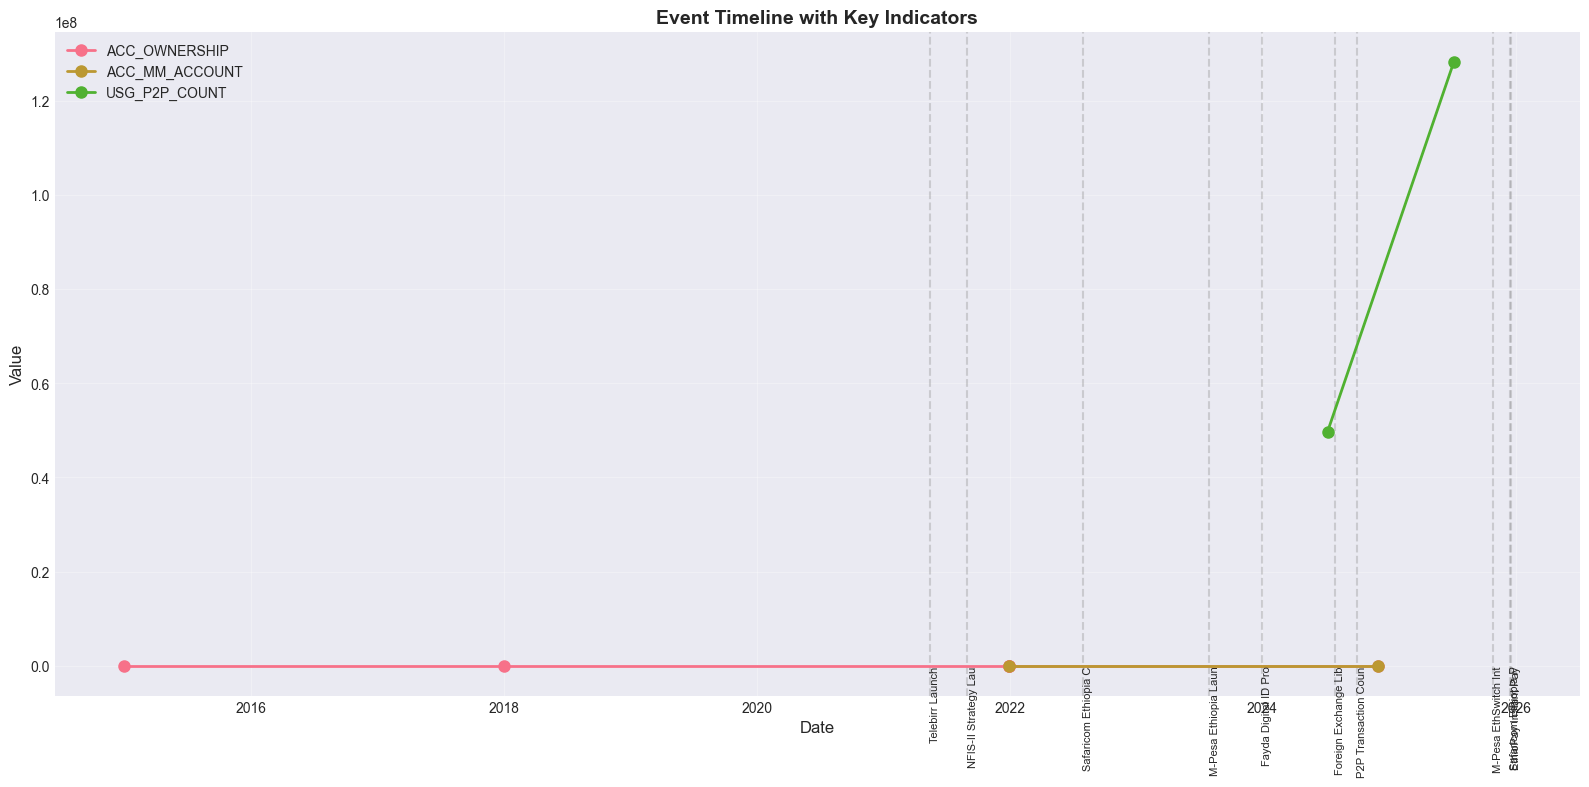

In [20]:
# Create event timeline with key indicators
fig, ax = plt.subplots(figsize=(16, 8))

# Plot events
for idx, row in events_df.iterrows():
    ax.axvline(row['event_date'], color='gray', linestyle='--', alpha=0.3)
    ax.text(row['event_date'], ax.get_ylim()[1]*0.95, row['indicator'][:20], 
           rotation=90, va='top', fontsize=8)

# Plot key indicators
for indicator_code in ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'USG_P2P_COUNT']:
    ind_data = indicators_df[indicators_df['indicator_code'] == indicator_code].copy()
    if not ind_data.empty:
        # Normalize to 0-100 scale for comparison
        ind_data = ind_data.sort_values('observation_date')
        ax.plot(ind_data['observation_date'], ind_data['value_numeric'], 
               marker='o', linewidth=2, label=indicator_code, markersize=8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Event Timeline with Key Indicators', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/event_timeline.png', dpi=300, bbox_inches='tight')
plt.show()